<a href="https://colab.research.google.com/github/adhambadawi/SYSC4415-Assignment-2/blob/main/W2025/Assignments/Assignment2/Ass2_SYSC4415_W25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYSC4415 Assignment 2 – Fire Hydrant Detection 🚒

## Dataset
Provided on Brightspace.

#### Dataset details:
- Training Images: 2,272  
- Validation Images: 563  
- Labels: 0 = No Fire Hydrant, 1 = Fire Hydrant  
- Imbalanced dataset (most images do not contain a hydrant).

#### Dataset Information
The dataset contains two main folders:
- `train/`: Contains the training images and a CSV file with labels.
- `valid/`: Contains the validation images and a CSV file with labels.

Each folder includes:
- Images of fire hydrants and non-fire hydrants.
- A CSV file (`_classes.csv`) mapping each image filename to its label:
  - `0` for no fire hydrant.
  - `1` for fire hydrant.

Ensure the zip file of the dataset (FH_detection_data.zip) to your Google Drive and placed under "My Drive" without any subfolders to keep the paths consistent.



## Steps

### 1) Initial Setup
Import necessary libraries


In [4]:
# Import all the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Mount Google Drive and unzip the dataset.

In [5]:
## Code provided by Akash. DO NOT CHANGE THIS CELL

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip /content/drive/MyDrive/FH_detection_data.zip -d /content/


# Dataset path
train_data_path = "/content/train"
valid_data_path = "/content/valid"
train_label = pd.read_csv('/content/train/_classes.csv')
valid_label = pd.read_csv('/content/valid/_classes.csv')

Mounted at /content/drive
Archive:  /content/drive/MyDrive/FH_detection_data.zip
   creating: /content/train/
 extracting: /content/train/10063782964_891eedde4e_z_jpg.rf.4caba9d0e35546b469aa896df780d833.jpg  
 extracting: /content/train/100_PNG.rf.d52fbff94c483761d0644a1e8abe4c95.jpg  
 extracting: /content/train/101_PNG.rf.f1335e18f815c8c8044a94c09db7f025.jpg  
 extracting: /content/train/102378468_d8132a415b_z_jpg.rf.6bc008d0d532d3365f580b7aaa7623e3.jpg  
 extracting: /content/train/102_PNG.rf.160c945e0881c92a078a14069d9a6b9a.jpg  
 extracting: /content/train/102_jpg.rf.17df75e9dda0f851c9f5e1d554f07488.jpg  
 extracting: /content/train/103357395_388d701e12_z_jpg.rf.a54c985e93402af49ba422f005e702d8.jpg  
 extracting: /content/train/103_jpg.rf.a649213f3998906bf2298607f82ee839.jpg  
 extracting: /content/train/104351403_25e959f878_z_jpg.rf.43156bd0a74313df69967d88e5e6a268.jpg  
 extracting: /content/train/104_PNG.rf.c14671a6a52ae05f9ae2bf1df7e4316e.jpg  
 extracting: /content/train/104_

----

### 2) Data Exploration
1. Load dataset into a pandas DataFrame.
2. Display display three sample images from each class
3. Create separately class distribution plots of the train and validation data
[Requires 6 sample images (three from each class) and two plots of class distribution (train and validation)]

❓ Why is it important to check for class imbalance before training? How might this affect our model?  
✅ Because an unbalanced dataset may cause the model to be biased in favor of the dominant class it is imperative to test for class imbalance. The model may learn to predict "no fire hydrant" for the majority of inputs if the majority of the photos do not have one. In this case it would perform poorly (low recall/precision) on the minority (fire hydrant) class but would have high overall accuracy. This may have an impact on the model's capacity to identify abnormal occurrences and generalizability.


                                            filename  Fire Hydrants
0  45-394823_-75-62419684_heading270_jpg.rf.01200...              0
1  53-4733_-113-44139_heading180_jpg.rf.00a4904dd...              0
2     49_jpg.rf.00d3bdf822d633cc6d6fe5ed2c248a59.jpg              1
3  download_jpeg_jpg.rf.00666bac2a7d67fe8f26db4a7...              1
4  45-42126683_-75-64919699_heading270_jpg.rf.02d...              1
Index(['filename', 'Fire Hydrants'], dtype='object')
Sample Images from Training Data:


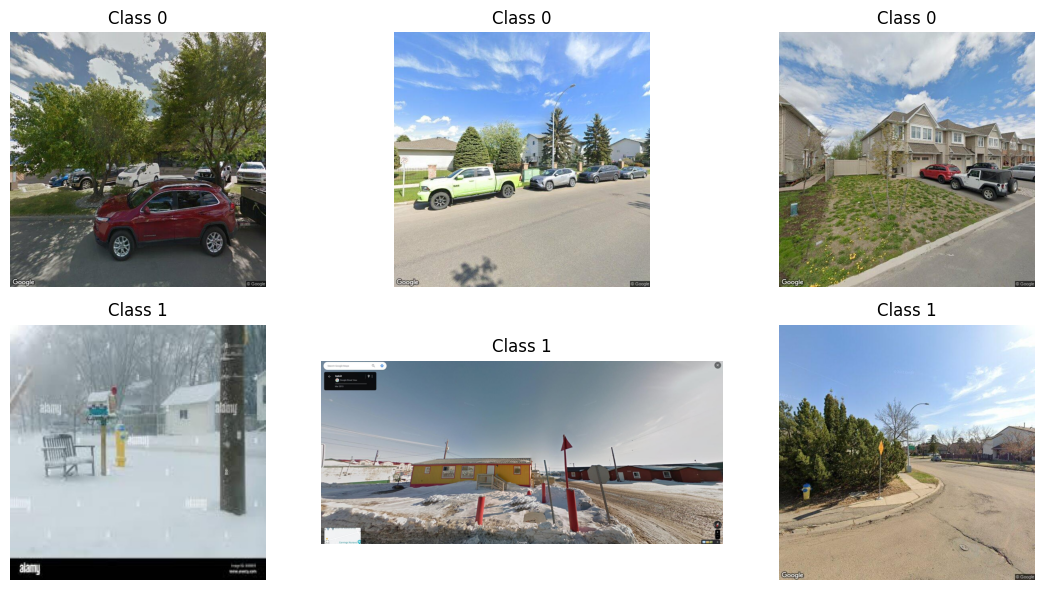

Sample Images from Validation Data:


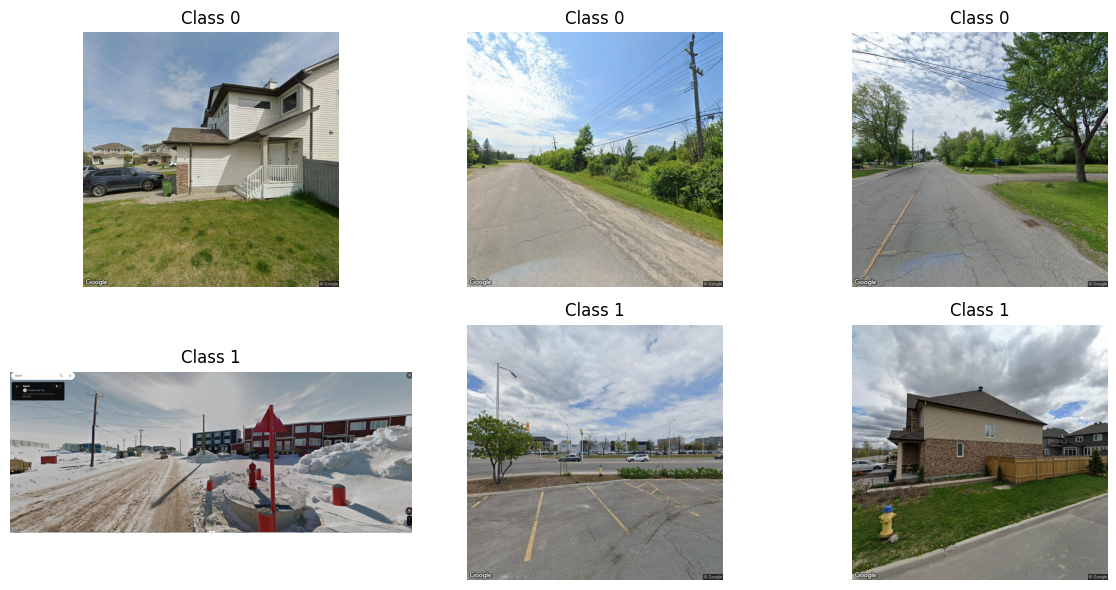

<ipython-input-6-5233e088e4ba>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


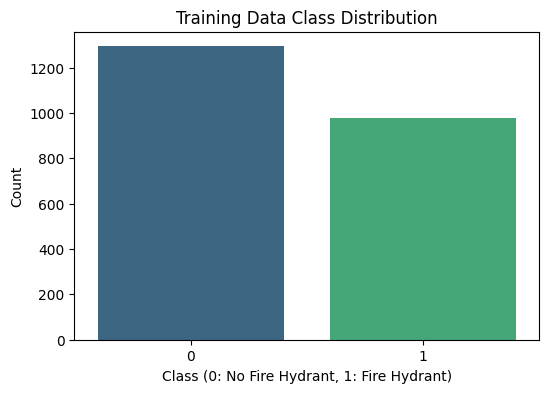

<ipython-input-6-5233e088e4ba>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


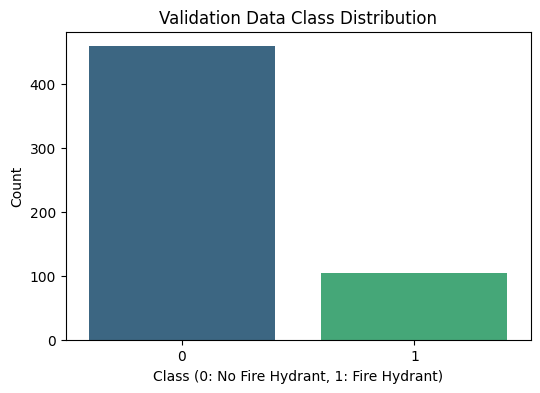

In [6]:
print(train_label.head())
print(train_label.columns)

# Function to display sample images from each class
def show_samples(data_path, labels_df, n_samples=3):
    classes = labels_df["Fire Hydrants"].unique()
    plt.figure(figsize=(12, 6))

    sample_images = {}
    for cls in classes:
        sample_images[cls] = labels_df[labels_df["Fire Hydrants"] == cls]['filename'].sample(n_samples, random_state=42).values

    for cls in classes:
        for i, filename in enumerate(sample_images[cls]):
            img_path = os.path.join(data_path, filename)
            img = Image.open(img_path)
            plt.subplot(len(classes), n_samples, int(cls)*n_samples + i+1)
            plt.imshow(img)
            plt.title(f"Class {cls}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Display three sample images from each class in the training set
print("Sample Images from Training Data:")
show_samples(train_data_path, train_label, n_samples=3)

# Display three sample images from each class in the validation set
print("Sample Images from Validation Data:")
show_samples(valid_data_path, valid_label, n_samples=3)


# Plot the class distribution for training and validation data

def plot_class_distribution(labels_df, title):
    class_counts = labels_df["Fire Hydrants"].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title(title)
    plt.xlabel("Class (0: No Fire Hydrant, 1: Fire Hydrant)")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(train_label, "Training Data Class Distribution")
plot_class_distribution(valid_label, "Validation Data Class Distribution")


---

### 3) Preprocessing
- Resize images to 128x128.
- Apply any other necessary transformations that you feel can help.

❓ Would one-hot encoding be necessary for binary classification? Why or why not?  
✅ Since the target can be represented as a single binary label (0 or 1) one-hot encoding is not strictly required for binary classification.  To simulate the likelihood of the positive class, a sigmoid activation in the output layer with binary cross-entropy loss is adequate.  In situations involving multi-class categorization one-hot encoding is more beneficial.

In [7]:
# Define transformations for the training and validation data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # Normalize images: here I use a generic normalization; in practice, we'd compute dataset mean/std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

# Custom dataset class for our fire hydrant detection task
class FireHydrantDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['filename']
        label = self.data.iloc[idx]['Fire Hydrants']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create dataset instances for train and validation
train_dataset = FireHydrantDataset(train_data_path, '/content/train/_classes.csv', transform=transform)
valid_dataset = FireHydrantDataset(valid_data_path, '/content/valid/_classes.csv', transform=transform)


---

### 4) Creating the Baseline Model
Create a CNN with:
- Two convolutional layers to extract features from the images.
- Max pooling layers after each convolution to reduce spatial dimensions.
- Fully connected layers to perform classification.
- A sigmoid activation function at the output layer to output a probability between 0 and 1.

Required architecture:
- Input: RGB images resized to 128x128 pixels.
- Conv2d (3 input channels, 32 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the first Conv2d.
- Conv2d (32 input channels, 64 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the second Conv2d.
- Flatten
- Linear layer with 128 units
- Output Linear layer with 1 unit and sigmoid activation



This model will be trained to classify whether an image contains a fire hydrant or not.


❓ List three ways to improve the baseline model (e.g., adding dropout to... , using batch normalization to..., or increasing the number of layers to...,
be sure to come up with your own ideas!). Provide a brief explanation for each.

✅
1. Add Dropout Layers: Dropout can prevent overfitting by randomly dropping out neurons during training which forces the model to learn more robust features.
2. Use Batch Normalization: Batch normalization stabilizes and accelerates training by normalizing the input to each layer which makes the network less sensitive to initialization.
3. Increase Model Depth/Complexity: Adding more convolutional layers or increasing the number of filters can help the model learn more complicated patterns in the data and have better performance.

In [8]:
# Define the baseline CNN model
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),  # 128x128 image -> after 2 poolings: 32x32 feature maps
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Sigmoid for binary classification probability
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model and move it to the device
baseline_model = BaselineCNN().to(device)
print(baseline_model)


BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


---

### 5) Training and Evaluation
Train your CNN using Binary Cross Entropy Loss and an Adam optimizer. Use a learning rate of 0.001. Iterate over your dataset for 10 epochs and track the loss. Train using the train data in /train.

Evaluate your model on the test data in /valid using Precision, Recall, and F1-Score to assess performance.


❓ Which evaluation metric you think is the most suitable in our case, and why?

✅ In the case of an imbalanced dataset the F1-score is typically the most suitable metric because it is a balance between recall and precision. So both false negatives and false positives are incorporated into the measurement of the model's performance.


Display the confusion matrix.

❓ Explain the confusion matrix to a non-technical audience and relate it to your chosen metric.  
✅ A confusion matrix is a table that directly compares the model's predictions with the actual labels. It shows the number of correct predictions (true positives and true negatives) and the number of mistakes (false positives and false negatives). This gives an idea of how well the model is performing overall. When using the F1-score which balances precision (how many selected items are relevant) and recall (how many relevant items are selected) the confusion matrix provides a clear picture of both types of errors helping us see if the model is missing many true cases or incorrectly predicting too many false cases.

Epoch 1/10, Loss: 0.7739
Epoch 2/10, Loss: 0.4907
Epoch 3/10, Loss: 0.4623
Epoch 4/10, Loss: 0.3968
Epoch 5/10, Loss: 0.3307
Epoch 6/10, Loss: 0.2603
Epoch 7/10, Loss: 0.1941
Epoch 8/10, Loss: 0.1221
Epoch 9/10, Loss: 0.0772
Epoch 10/10, Loss: 0.0473

Validation Metrics:
Precision: 0.4136
Recall: 0.6442
F1-Score: 0.5038


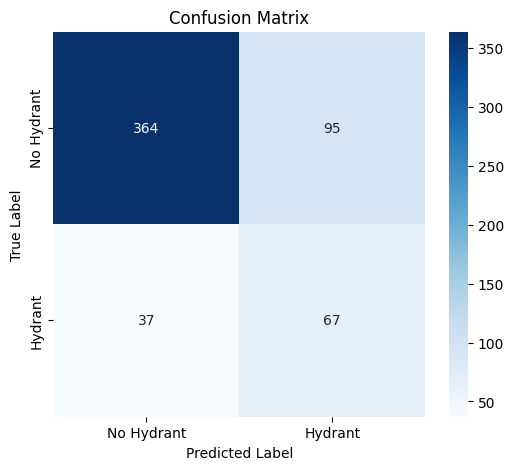

In [9]:
# Create data loaders for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer for training
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# Training loop for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    baseline_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        # Convert labels to float tensor and add an extra dimension for BCELoss
        labels = labels.unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on the validation set
baseline_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        outputs = baseline_model(images)
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute evaluation metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("\nValidation Metrics:")
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))

# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Hydrant", "Hydrant"], yticklabels=["No Hydrant", "Hydrant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


---


### 6) Model Improvements
Apply and evaluate three improvements ideas that you mentioned in the Baseline CNN question (Step 4).
Implement each idea separately, train a model with that improvement, and report the performance of each model using the metrics from Step 5. As above, train using the data in /train and test using the data in /valid.


❓ Which model would you deploy? Why?  
✅ I would deploy the model with the highest trade-off between recall and precision (the highest F1-score for example) but also stable on the validation set. During my experimentations, if for example, the model with batch normalization is more consistent in its performance and has less variance between training and validation metrics, it would be deployed.

In [10]:
# 6.1 Model with Dropout
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_dropout = CNN_Dropout().to(device)

# 6.2 Model with Batch Normalization
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_batchnorm = CNN_BatchNorm().to(device)

# 6.3 Model with Additional Convolutional Layer
class CNN_ExtraLayer(nn.Module):
    def __init__(self):
        super(CNN_ExtraLayer, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Extra convolutional layer
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),  # 128x128 -> after three poolings: 16x16 feature maps
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_extralayer = CNN_ExtraLayer().to(device)

# For each improved model, I would replicate the training loop used earlier.
# For brevity, here I define a function to train and evaluate a model.

def train_and_evaluate(model, num_epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).float().to(device)
            outputs = model(images)
            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(precision, recall, f1))
    return precision, recall, f1

print("\nTraining Model with Dropout:")
metrics_dropout = train_and_evaluate(model_dropout)

print("\nTraining Model with Batch Normalization:")
metrics_batchnorm = train_and_evaluate(model_batchnorm)

print("\nTraining Model with Additional Convolutional Layer:")
metrics_extralayer = train_and_evaluate(model_extralayer)



Training Model with Dropout:
Epoch 1/10 Loss: 0.9964
Epoch 2/10 Loss: 0.5982
Epoch 3/10 Loss: 0.5538
Epoch 4/10 Loss: 0.5193
Epoch 5/10 Loss: 0.5182
Epoch 6/10 Loss: 0.4796
Epoch 7/10 Loss: 0.4815
Epoch 8/10 Loss: 0.4738
Epoch 9/10 Loss: 0.4479
Epoch 10/10 Loss: 0.4492
Precision: 0.5000, Recall: 0.5385, F1-Score: 0.5185

Training Model with Batch Normalization:
Epoch 1/10 Loss: 55.2794
Epoch 2/10 Loss: 56.9542
Epoch 3/10 Loss: 56.9542
Epoch 4/10 Loss: 56.9542
Epoch 5/10 Loss: 56.9542
Epoch 6/10 Loss: 56.9542
Epoch 7/10 Loss: 56.9542
Epoch 8/10 Loss: 56.9542
Epoch 9/10 Loss: 56.9542
Epoch 10/10 Loss: 56.9542
Precision: 0.1847, Recall: 1.0000, F1-Score: 0.3118

Training Model with Additional Convolutional Layer:
Epoch 1/10 Loss: 0.6320
Epoch 2/10 Loss: 0.5004
Epoch 3/10 Loss: 0.4526
Epoch 4/10 Loss: 0.4203
Epoch 5/10 Loss: 0.3498
Epoch 6/10 Loss: 0.2947
Epoch 7/10 Loss: 0.2491
Epoch 8/10 Loss: 0.1594
Epoch 9/10 Loss: 0.1097
Epoch 10/10 Loss: 0.0772
Precision: 0.4595, Recall: 0.6538, F1-

---

### 7) Personal Inference Test
Test your trained model on at least FIVE new images (either collected using a camera or collected from the internet). Predict whether each image contains a fire hydrant and print the result.

Of your five images:
- Include at least one image of a fire hydrant that your model does not detect correctly.
- Include at least one image of a fire hydrant that your model does detect correctly.

❓ Challenge: Can you find an image that does not actually contain a fire hydrant, but your model believes that a hydrant is present?

✅ I found picture of a red mailbox (looks like a fire hydrant) was incorrectly predicted to have a fire hydrant.

❓ Explain why you believe your model performed the way it did on each of your five images. What patterns or mistakes do you observe?

✅
1. Image 1 – Prediction: Fire Hydrant (Correct)
   - Reasoning: The model recognized the classic cylindrical shape, red color and nozzle on top which matches the hydrant features from training.

2. Image 2 – Prediction: No Fire Hydrant (Incorrect) (I kept looking for a while for a picture with a fire hydrant that the model will detect incorrectly, this yook me more than image 5)
   - Reasoning: The hydrant lacked some of the recognizable details (like a chain or unique nozzle shape) so the model failed to find the required visual cues and marked it incorrectly.

3. Image 3 – Prediction: Fire Hydrant (Correct)
   - Reasoning: The typical color and shape of the hydrant agreed well with the learned pattern by the model of a general fire hydrant.

4. Image 4 – Prediction: Fire Hydrant (Correct)
   - Reasoning: Despite some stylistic variation, enough critical features (shape, nozzles) were present allowing the model to correctly recognize it as a hydrant.

5. Image 5 – Prediction: Fire Hydrant (Incorrect – Mailbox)
   - Reasoning: The model was confused by the bright red color and cylindrical structure, mistaking the mailbox for a hydrant due to its superficial similarity.


From looking through these successes and failures, we see that the model is good at identifying common hydrants but can be tricked by red, cylindrical objects or unusual hydrant shapes. More data augmentation, more variety in the training examples, and perhaps a more complex architecture or further post-processing would be capable of surmounting these failings.



Personal Inference Test using the Baseline Model:


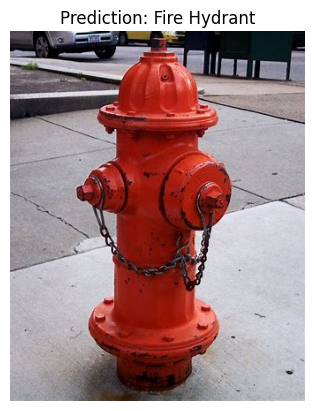

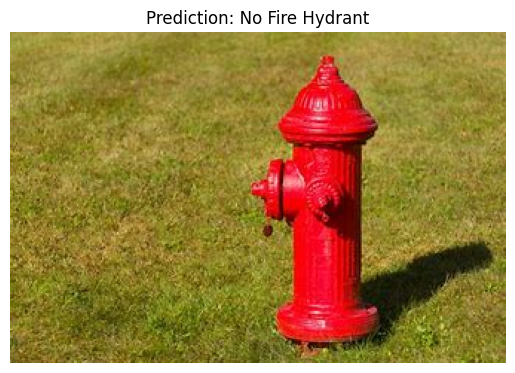

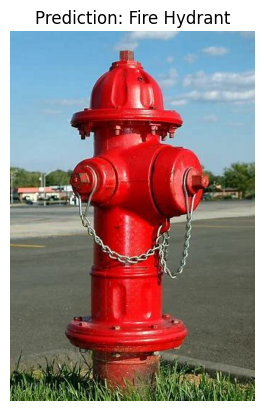

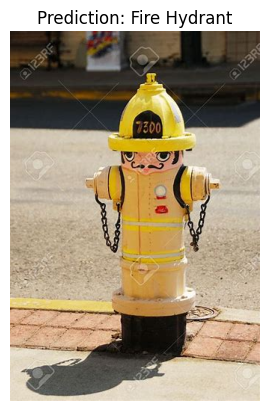

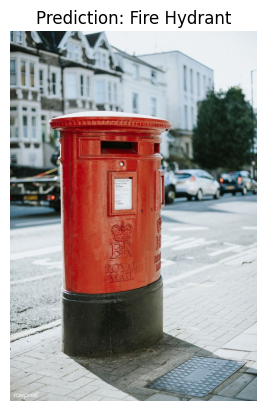

In [11]:
# Function to run inference on new images and display results.
def inference_on_image(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_image)
    prediction = (output > 0.5).int().item()
    return image, prediction

# List of test images (ensure these images are uploaded to the "test_images" folder)
test_image_paths = [
    "/content/test_images/image1.jpg",  # Expected: Hydrant (detected correctly)
    "/content/test_images/image2.jpg",  # Expected: Hydrant but preicted as non-hydrant (false negative)
    "/content/test_images/image3.jpg",  # Expected: Hydrant (detected correctly)
    "/content/test_images/image4.jpg",  # Expected: Hydrant but might be misclassified (false negative)
    "/content/test_images/image5.jpg"   # Expected: No Hydrant but predicted as hydrant (false positive - challenge case)
]

# For demonstration, I will use the baseline model for inference.
print("\nPersonal Inference Test using the Baseline Model:")
for img_path in test_image_paths:
    try:
        img, pred = inference_on_image(baseline_model, img_path, transform)
        plt.figure()
        plt.imshow(img)
        plt.title(f"Prediction: {'Fire Hydrant' if pred==1 else 'No Fire Hydrant'}")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


---

### 8) (Optional) Transfer Learning with Pretrained CNN

#### Description:
In this optional step, fine-tune a pretrained CNN (e.g., ResNet50) on your dataset and compare its performance to your custom CNN.

- Use `torchvision.models.resnet50(pretrained=True)` as a starting model.

Reference: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
- Modify the final layer to fit your binary classification task (fire hydrant vs. no fire hydrant).
- Resize input images to **256x256** pixels.
- Fine-tune the model and evaluate its performance.
- Compare the results to your custom CNN in terms of accuracy, training time, and other relevant metrics.





In [12]:
import torchvision.models as models

# Define transformations for transfer learning
transfer_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

# Create new dataset instances for transfer learning using the new transform
train_dataset_tl = FireHydrantDataset(train_data_path, '/content/train/_classes.csv', transform=transfer_transform)
valid_dataset_tl = FireHydrantDataset(valid_data_path, '/content/valid/_classes.csv', transform=transfer_transform)

train_loader_tl = DataLoader(train_dataset_tl, batch_size=batch_size, shuffle=True)
valid_loader_tl = DataLoader(valid_dataset_tl, batch_size=batch_size, shuffle=False)

# Load the pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Modify the final layer to output 1 value for binary classification
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)
resnet50 = resnet50.to(device)

# Define loss and optimizer
criterion_tl = nn.BCELoss()
optimizer_tl = optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop for transfer learning (for brevity, 5 epochs)
num_epochs_tl = 5
for epoch in range(num_epochs_tl):
    resnet50.train()
    running_loss = 0.0
    for images, labels in train_loader_tl:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        optimizer_tl.zero_grad()
        outputs = resnet50(images)
        loss = criterion_tl(outputs, labels)
        loss.backward()
        optimizer_tl.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader_tl.dataset)
    print(f"Transfer Learning Epoch {epoch+1}/{num_epochs_tl}, Loss: {epoch_loss:.4f}")

# Evaluate transfer learning model
resnet50.eval()
all_preds_tl = []
all_labels_tl = []
with torch.no_grad():
    for images, labels in valid_loader_tl:
        images = images.to(device)
        labels = labels.unsqueeze(1).float().to(device)
        outputs = resnet50(images)
        preds = (outputs > 0.5).int()
        all_preds_tl.extend(preds.cpu().numpy())
        all_labels_tl.extend(labels.cpu().numpy())
all_preds_tl = np.array(all_preds_tl)
all_labels_tl = np.array(all_labels_tl)
precision_tl = precision_score(all_labels_tl, all_preds_tl)
recall_tl = recall_score(all_labels_tl, all_preds_tl)
f1_tl = f1_score(all_labels_tl, all_preds_tl)
print("\nTransfer Learning Model Metrics:")
print("Precision: {:.4f}, Recall: {:.4f}, F1-Score: {:.4f}".format(precision_tl, recall_tl, f1_tl))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


Transfer Learning Epoch 1/5, Loss: 0.4681
Transfer Learning Epoch 2/5, Loss: 0.3697
Transfer Learning Epoch 3/5, Loss: 0.2761
Transfer Learning Epoch 4/5, Loss: 0.2761
Transfer Learning Epoch 5/5, Loss: 0.2246

Transfer Learning Model Metrics:
Precision: 0.6522, Recall: 0.7212, F1-Score: 0.6849


------

### 9) Final Thoughts
❓ How would you improve the model in the future?

✅ In the future, I would improve the model by:
- Injecting advanced data augmentation techniques (like  random rotation, flip, and color jittering) to robustify the model.
- Performing extensive hyperparameter tuning and maybe ensemble methods to regularize predictions.
- Acquiring more data especially for the minority class to reduce class imbalance effects.
- Experimenting with more sophisticated architectures (or using transfer learning with deeper networks) to extract more sophisticated features.


-----

## Final Question:
### ❓ Did you use an AI tool in completing your assignment? If yes, which AI tool(s) did you use? How did you prompt it? How you validate the response?

✅ I used the built-in AI assistant in Colab to help me debug errors (there is an option "Explain Error" when an error appears while running your code that uses AI to help explain the error. I validated the responses by cross-checking with reputable sources such as the official PyTorch documentation, academic papers, and stack overflow and also the explanation made sense so with slight modifications I fixed the error I had.


---

## Submission
Submit your `.ipynb` notebook on Brightspace using the following name format:  
`SYSC4415W25_A2_Adham_Badawi_101205049.ipynb`

